### Setup

In [21]:
from typing import List
from openai import OpenAI
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt


with open("qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

### Vertex Conversation and Search

#### Setup

In [22]:
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine_v1 as discoveryengine


# The 3 variables below need to be obtained from your GCP account.
# The data_store_id is the data store created in Vertex AI Search and Conversation.
# To load data simply upload the ~200 essays in examples/titan_vs_cohere/paul_graham_essays into a GCS bucket and reference the bucket from your data store. 
project_id=''
data_store_id=''
location='global'

def get_vertex_response(benchMarkItem: BenchmarkItem) -> List[discoveryengine.SearchResponse]:
    
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )

    client = discoveryengine.SearchServiceClient(client_options=client_options)

    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=data_store_id,
        serving_config="default_config",
    )

    content_search_spec = discoveryengine.SearchRequest.ContentSearchSpec(
        snippet_spec=discoveryengine.SearchRequest.ContentSearchSpec.SnippetSpec(
            return_snippet=True
        ),
        summary_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec(
            summary_result_count=5,
            include_citations=True,
            ignore_adversarial_query=True,
            ignore_non_summary_seeking_query=True,
        ),
    )
    
    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=benchMarkItem.question,
        page_size=10,
        content_search_spec=content_search_spec,
        query_expansion_spec=discoveryengine.SearchRequest.QueryExpansionSpec(
            condition=discoveryengine.SearchRequest.QueryExpansionSpec.Condition.AUTO,
        ),
        spell_correction_spec=discoveryengine.SearchRequest.SpellCorrectionSpec(
            mode=discoveryengine.SearchRequest.SpellCorrectionSpec.Mode.AUTO
        ),
    )

    response = client.search(request)
    return response.summary.summary_text

#### Testing

In [23]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_vertex_response(benchmark_item))

According to Paul Graham, you only need two kinds of people to create a technology hub: rich people and nerds [1]. To create a startup hub, you need to establish a first-rate research university in a place so nice that rich people wanted to live there [4]. The town would be hospitable to both groups you need: both founders and investors [4].


##### Run through all the questions

In [24]:
with ThreadPoolExecutor(max_workers=10) as executor:
    raw_vertex_responses = list(tqdm(executor.map(get_vertex_response, benchmark.items), total=len(benchmark.items)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:24<00:00,  2.24it/s]


In [25]:
vertex_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_vertex_responses, benchmark.items)
]

In [26]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
vertex_run = scorer.score_run(vertex_responses)

In [28]:
vertex_run_df = run_to_dataframe(vertex_run)
vertex_run_df.to_csv("vertex_run.csv", index=False)

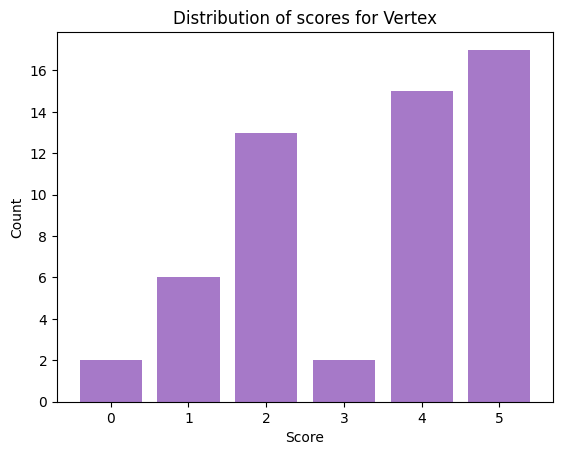

In [29]:
vertex_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in vertex_run.run_data])
category_counts = vertex_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for Vertex')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

### OpenAI Rag Assistant

#### Setup

In [30]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question    
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_retries = 10
    base = 0.1
    num_retries = 0
    try:
        while max_retries > 0:
            if max_retries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            if len(messages.data)>0 and len(messages.data[0].content)>0:
                response_message = messages.data[0].content[0].text.value
                if response_message != prompt and response_message.strip():
                    annotations = messages.data[0].content[0].text.annotations
                    quotes = [x.file_citation.quote for x in annotations if x.file_citation]
                    client.beta.threads.delete(thread.id)
                    return response_message
            time.sleep(base * (2 ** num_retries))
            num_retries += 1
            max_retries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e

#openai rag only supports a max of 20 files. So we just combine all essays into single file
def upload_essay():
    file_ids=[]
    with open("all_essays_in_single_file.txt", 'rb') as essay_file:
        file = client.files.create(
            file=essay_file,
            purpose='assistants'
        )   
        file_ids.append(file.id)
    return file_ids

def create_assistant(file_ids):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test {len(file_ids)} Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-1106-preview",
        tools=[{"type": "retrieval"}],
        file_ids=file_ids
    )

def setup_assistant():
    file_ids = upload_essay()
    return create_assistant(file_ids)

# WARNING
# this deletes all files associated with your openai api key.
#def cleanup_files():
#    for f in client.files.list():
#        client.files.delete(f.id)
#        time.sleep(1)

#### Testing

In [31]:
client = OpenAI()
assistant = setup_assistant()

In [32]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant))

According to Paul Graham, key components necessary to create a technology hub or attract the "creative class" include the following:

1. **Personality and Character**: A town must have personality, which usually means avoiding mass-produced environments and having a variety of unique and densely packed buildings. Graham suggests that building codes should ensure density and ban large-scale developments【9†source】.

2. **Right Personality for Nerds**: Since many technology hubs are formed by nerds, a city must appeal to their tastes, which differ from the rest of the creative class. Nerds tend to like places where people are friendlier and prefer quieter pleasures like cafes, bookshops, and areas with natural beauty. A nerd's idea of paradise would be places like Berkeley or Boulder【10†source】.

3. **Youth Appeal**: Technology hubs tend to be youthful in feel and having an intact city center is important, as young people do not want to live in the suburbs. Boulder and Portland are cited 

##### Run through all the questions

In [33]:
raw_openai_responses = []
for x in tqdm(benchmark.items):
    raw_openai_responses.append(get_openai_rag_response(x, assistant))    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [33:28<00:00, 36.51s/it]


In [34]:
openai_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [35]:
scorer = ValidateScorer([AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses)

In [36]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv("openai_run.csv", index=False)

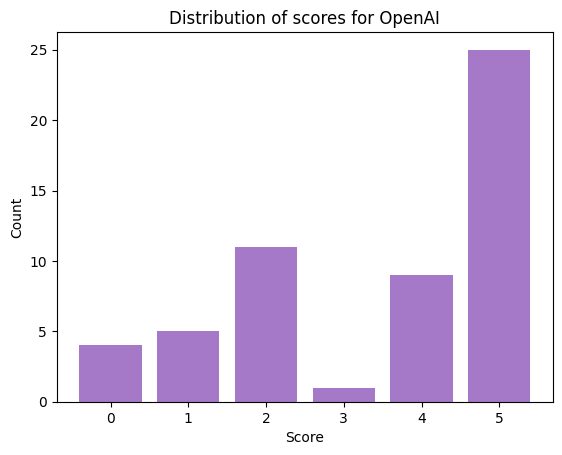

In [37]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()

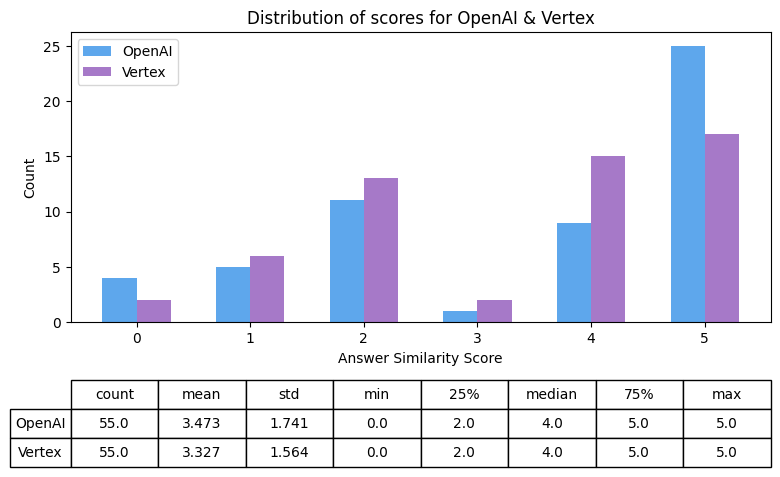

In [38]:
import matplotlib.pyplot as plt
import numpy as np

openai_run_df = pd.read_csv("openai_run.csv")
vertex_run_df = pd.read_csv("vertex_run.csv")

combined_scores = pd.DataFrame({
    "OpenAI": list(openai_run_df["answer_similarity"]),
    "Vertex": list(vertex_run_df["answer_similarity"])
})

# Position of bars on x-axis
ind = np.arange(6)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3

openai_counts = combined_scores["OpenAI"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(openai_counts.index, openai_counts.values, width, label="OpenAI", color="#5EA7EC")

vertex_counts = combined_scores["Vertex"].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
plt.bar(vertex_counts.index + width, vertex_counts.values, width, label="Vertex", color="#A679C8")

plt.title('Distribution of scores for OpenAI & Vertex')
plt.xlabel('Answer Similarity Score')
plt.ylabel('Count')

# Remove all scores except whole numbers
plt.xticks(ind + width / 2, range(0, 6, 1))

plt.legend(loc='best')

# Rounding the descriptive statistics to 3 significant figures
statistics_df = combined_scores.describe()
# Change 50% to 50% (median)
statistics_df = statistics_df.rename(index={'50%': 'median'})
rounded_statistics_df = statistics_df.round(3)

# Transposing the descriptive statistics table for horizontal display
rounded_statistics_df = rounded_statistics_df.T

# Adding the table below the histogram
table = plt.table(cellText=rounded_statistics_df.values,
                  colWidths=[0.1] * len(rounded_statistics_df.columns),
                  rowLabels=rounded_statistics_df.index,
                  colLabels=rounded_statistics_df.columns,
                  cellLoc = 'center', rowLoc = 'center',
                  loc='bottom', bbox=[0.0, -0.5, 1.0, 0.3])

plt.subplots_adjust(left=0.2, bottom=0.3)
plt.savefig("openai_v_vertex.png", facecolor='white', bbox_inches='tight')

plt.show()